In [1]:
import csv
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# DeepMoD stuff
from deepymod import DeepMoD
from deepymod.model.func_approx import NN, Siren
from deepymod.model.library import Library1D
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Clustering, Threshold, PDEFIND
from deepymod.training import train
from deepymod.analysis import load_tensorboard
from derivatives import library, finite_diff, spline_diff

# %% Imports
from scipy.ndimage import convolve1d
from scipy.interpolate import UnivariateSpline
import numpy as np
from deepymod.data import Dataset
from deepymod.data.burgers import BurgersDelta
from sklearn.linear_model import LassoCV

from deepymod.training.sparsity_scheduler import TrainTestPeriodic
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
# %% Functions
def finite_diff(y, x, order, axis=0, bc_mode='reflect'):
    ''' Calculates finite difference of order n over axis. 
    Uses 2nd order accurate central difference.'''
    step_size = np.diff(x)[0] # assumes step size is constant
    if order == 1:
        stencil = np.array([1/2, 0, -1/2])
    elif order == 2:
        stencil = np.array([1, -2, 1])
    elif order == 3:
        stencil = np.array([1/2, -1, 0, 1, -1/2])
    else:
        raise NotImplementedError

    deriv = convolve1d(y, stencil, axis=axis, mode=bc_mode) / step_size**order
    return deriv


def spline_diff(y, x, order, **spline_kwargs):
    """Fits spline to data and returns derivatives of given order. order=0 corresponds to data.
    Good defaults for spline, k=4, s=1e-2/0.0 if not smooth"""
    spline = UnivariateSpline(x, y, **spline_kwargs)
    return spline(x, nu=order)


def library(y, x, t, poly_order=2, deriv_order=3, deriv_kind='spline', **deriv_kwargs):
    ''' Returns time deriv and library of given data. x and t are vectors, first axis of y should be time.'''
    if deriv_kind == 'spline':
        # Calculating polynomials
        u = np.stack([spline_diff(y[frame, :], x, order=0, **deriv_kwargs) for frame in np.arange(t.size)], axis=0).reshape(-1, 1) # if we do a spline on noisy data, we also get a 'denoised' data
        u = np.concatenate([u**order for order in np.arange(poly_order+1)], axis=1) # getting polynomials including offset

        # Calculating derivatives
        du = [np.ones((u.shape[0], 1))]
        for order in np.arange(1, deriv_order+1):
            du.append(np.stack([spline_diff(y[frame, :], x, order=order, **deriv_kwargs) for frame in np.arange(t.size)], axis=0).reshape(-1, 1)) 
        du = np.concatenate(du, axis=1)

        # Calculating theta
        theta = (u[:, :, None] @ du[:, None, :]).reshape(-1, u.shape[1] * du.shape[1])
      
    elif deriv_kind == 'fd':
        # Calculating polynomials
        u = np.concatenate([(y**order).reshape(-1, 1) for order in np.arange(poly_order+1)], axis=1)

        # Getting derivatives
        du = np.concatenate([(finite_diff(y, x, order=order, axis=1, **deriv_kwargs)).reshape(-1, 1) for order in np.arange(1, deriv_order+1)], axis=1)
        du = np.concatenate((np.ones((du.shape[0], 1)), du), axis=1)

        # Calculating theta
        theta = (u[:, :, None] @ du[:, None, :]).reshape(-1, u.shape[1] * du.shape[1])

    else:
        raise NotImplementedError
    # Calculating time diff by finite diff
    dt = finite_diff(u[:, 1].reshape(t.size, x.size), t, order=1, axis=0).reshape(-1, 1)
    return dt, theta



In [3]:
# Loading and scaling the data

lower_lim, upper_lim = 540, 3000 
delta_V = np.load('11_elements.npy')
y = delta_V[lower_lim:upper_lim,:]
y = y/np.max(y)
t = np.linspace(0, 1, y.shape[0])
x = np.linspace(0, 1, y.shape[1])

In [4]:
threshold = 0.2
exp_list = [13,11,9,7,5]
xi_list = []
for i in exp_list:
    delta_V = np.load(str(i)+'_elements.npy')
    output_data = delta_V[lower_lim:upper_lim,:]
    output_data = output_data/np.max(output_data)
    t = np.linspace(0, 1, output_data.shape[0])
    x = np.linspace(0, 1, output_data.shape[1])
    dt, theta = library(output_data, x, t, deriv_kind='spline',poly_order=1,deriv_order=2, s=0.01, k=4)
    theta = theta/np.linalg.norm(theta,axis=0)
    dt = dt/np.linalg.norm(dt,axis=0)
    reg = LassoCV(fit_intercept=False, cv=25)
    xi = reg.fit(theta, dt).coef_[:, None].flatten()
    xi[np.abs(xi) < threshold] = 0
    xi_list.append(xi)

In [5]:
theta/np.linalg.norm(theta,axis=0)

array([[ 9.01669635e-03, -4.83699244e-02,  5.88134110e-02,
         4.69304886e-03, -2.39325617e-02,  2.98836782e-02],
       [ 9.01669635e-03, -7.60656069e-03,  2.04568386e-02,
         4.08091206e-04, -3.27268550e-04,  9.03854161e-04],
       [ 9.01669635e-03,  1.56032014e-03, -3.65300690e-04,
         2.04045603e-04,  3.35660052e-05, -8.07012644e-06],
       ...,
       [ 9.01669635e-03, -4.29088039e-03,  9.13251724e-04,
         9.38609773e-03, -4.24609965e-03,  9.28064540e-04],
       [ 9.01669635e-03, -2.34048021e-03,  3.10505586e-03,
         8.77396092e-03, -2.16500733e-03,  2.94963121e-03],
       [ 9.01669635e-03,  3.12064028e-03,  7.48866414e-03,
         8.77396092e-03,  2.88667644e-03,  7.11381646e-03]])

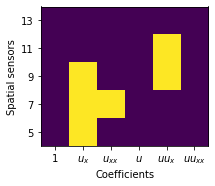

In [6]:
plt.figure(figsize=(3, 3))
plt.imshow(np.abs(np.array(xi_list).reshape(5,6)),vmin=0, vmax=0.01)
plt.xlabel('Coefficients')
plt.ylabel('Spatial sensors')
plt.yticks([0,1,2,3,4],['13', '11', '9', '7','5'])
plt.xticks([0,1,2,3,4,5],[1,'$u_x$','$u_{xx}$','$u$','$u u_x$','$u u_{xx}$' ])
plt.savefig('cable_eq_spline.pdf')

y has time on the first axis and space on the second 

In [71]:
y.shape

(2460, 11)

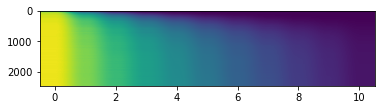

In [72]:
plt.imshow(y,aspect=0.001)

In [74]:
threshold = 0.1
dt, theta = library(y, x, t, deriv_kind='spline',poly_order=1,deriv_order=2, s=0.0001, k=3)
reg = LassoCV(fit_intercept=False, cv=10)
xi = reg.fit(theta, dt).coef_[:, None].flatten()
xi[np.abs(xi) < threshold] = 0
print(xi)

[-0.7381601  -2.55925127  0.28890833 -3.07423606  0.65597657 -0.35623913]


In [75]:
noise = 0.02
A = 1
v = 0.25

runs = 1
dataset = Dataset(BurgersDelta, A=A, v=v)
n_x, n_t = 100, 50 
x = np.linspace(-2, 2, n_x)
t = np.linspace(0.1, 1.1, n_t) 
t_grid, x_grid = np.meshgrid(t, x, indexing='ij')
X, y = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=0, noise=noise, random=False, normalize=False)
y= y.reshape(t.shape[0],x.shape[0]).numpy()

y has time on the first axis and space on the second 

In [76]:
y.shape

(50, 100)

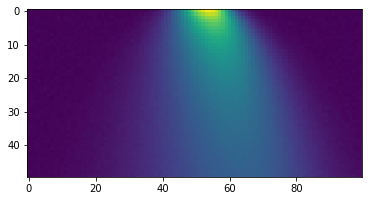

In [77]:
plt.imshow(y,aspect=1)

In [78]:
threshold = 0.1
dt, theta = library(y, x, t, deriv_kind='spline',poly_order=1,deriv_order=2, s=0.00, k=3)
reg = LassoCV(fit_intercept=False, cv=10)
xi = reg.fit(theta, dt).coef_[:, None].flatten()
xi[np.abs(xi) < threshold] = 0
print(xi)

[ 0.2941514  -0.38277507  0.         -1.16642921 -0.24891237  0.        ]
